In [1]:
%matplotlib inline
import os
import math
import numpy as np
import heapq
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import scale
from scipy.special import gammaincc
import matplotlib.pyplot as plt
path = os.getcwd()

In [2]:
def likelihood_ratio_test(fm_ll, fm_features, rm_ll, rm_features):
    D = 2 * (fm_ll - rm_ll)
    df = fm_features - rm_features
    return D, gammaincc(df/2, D/2)

In [3]:
def create_model(X,y,features=0, regularization='l2',Cvalue=1e10):
    if features==0: #Full model
        features=list(range(X.shape[1]))
    if not features: #Null model
        model = LogisticRegression(penalty=regularization,dual=False,C=Cvalue,solver='liblinear').fit(np.zeros([X.shape[0],1]),y)
        predict_probabilities = model.predict_proba(np.zeros([X.shape[0],1]))
        log_likelihood = -log_loss(y, predict_probabilities, normalize=False)
        return model, log_likelihood, predict_probabilities, y
    else: #Reduced/Full model
        model = LogisticRegression(penalty=regularization,dual=False,C=Cvalue,solver='liblinear').fit(X[:,features],y)
        predict_probabilities = model.predict_proba(X[:,features])
        log_likelihood = -log_loss(y, predict_probabilities, normalize=False)
        return model, log_likelihood, predict_probabilities, y

In [4]:
def get_Data():
    data = np.genfromtxt(os.path.join(path,'data','SAheart.csv'),dtype=np.string_,delimiter=',')[1:,:]
    for dataSet in data:
        if dataSet[4]==b'"Present"':
            dataSet[4]=b'1'
        else:
            dataSet[4]=b'0'
    X = data[:,:-1].astype('float')
    y = data[:,-1].astype('int')
    return X,y

In [5]:
X,y = get_Data()

South African Heart Disease

a) Create a model that contains only the intercept (null model), i.e. no features are considered.

In [6]:
nm = create_model(X,y,[])

b) Create multiple models each considering a single feature. Note that famhist is a categorical feature which has to be converted to numbers first.

In [7]:
sfm = []
for feature in range(X.shape[1]):
    sfm.append(create_model(X,y,[feature]))

c) Create a function likelihood_ratio_test implementing the likelihood-ratio test which takes the log-likelihood of the full model and the reduced model (Section 1.1). Use this function to compare the single feature models to the null model. Which feature yields the most significant improvement over the null model?

In [8]:
lr_test=[]
for model in sfm:
    d,p = likelihood_ratio_test(model[1],1,nm[1],0)
    lr_test.append(d)
    print ('Feature '+str(len(lr_test))+': D='+str(d)+', p='+str(p))
    
print ('')
print ("=> Feature "+str(np.argmax(lr_test)+1)+" (improvement: D="+str(max(lr_test))+")")

Feature 1: D=16.7861004034, p=4.18386430336e-05
Feature 2: D=41.4609713246, p=1.20247801881e-10
Feature 3: D=31.8295979469, p=1.68308309592e-08
Feature 4: D=31.0570666514, p=2.50552467184e-08
Feature 5: D=34.2140610071, p=4.93709334487e-09
Feature 6: D=4.98036018259, p=0.0256366451805
Feature 7: D=4.57982412447, p=0.0323505351071
Feature 8: D=1.76297400184, p=0.184253997327
Feature 9: D=70.5460725687, p=4.49641841771e-17

=> Feature 9 (improvement: D=70.5460725687)


d) What do the estimated coefficients tell with respect to the odds of suffering from myocardial infarction? Make sure you consider the p-value of the likelihood-ratio test as well.

- Null model yields the prior probabilities for both classes, i.e. the class ratio of all data points.
- In gereral, Logistic Regression models are linear with respect to the log-odds-ratio. Therefore the coefficients indicate by how much this ratio will change if the value of a feature is changed. High coefficient values mean that a feature has a high influence on the odds of suffering from myocardial infarction.
- This can also be seen by looking at the p-values. If p is close to 1, chances are that the extended model describes the same underlying distribution as the reduced model. If p is close to 0, this is highly unlikely and the extended model probably contains important new information.

e) Create a model which considers multiple features by starting with the null model and adding one additional feature at a time. To determine which feature to add, use the p-value as returned by the likelihood-ratio test. Extended models with one additional feature, where the p-value is greater than 0.05, should not be considered. In each step choose the model with the smallest p-value. Continue until all features have been selected or the model cannot be improved significantly any more. Print all selected features.

In [9]:
features = []
while True:
    model = create_model(X,y,features)
    add_features = list(set(range(X.shape[1])) - set(features))
    if not add_features:
        break
    lr_test = []
    for f in add_features:
        new_features = features.copy()
        new_features.append(f)
        new_model = create_model(X,y,new_features)
        lr_test.append(likelihood_ratio_test(new_model[1],len(new_features),model[1],len(features))[1])
    if np.min(lr_test)>0.05:
        break
    else:
        print ('Feature '+str(add_features[np.argmin(lr_test)]+1)+': p='+str(np.min(lr_test)))
        features.append(add_features[np.argmin(lr_test)])
rm = model

Feature 9: p=4.49641841771e-17
Feature 5: p=1.37464174551e-05
Feature 2: p=0.000786447034068
Feature 6: p=0.00108825916418
Feature 3: p=0.00265761619885


f) L1 (lasso) regularization can also be used for feature selection. Consider a full model with all 10 features as input, penalized with the L1 norm of coefficients (try regularization parameter C in the range of 0.01 − 0.1). Features with an non-zero coefficient are important for the classification. Compare the Lasso-selected features to the features selected by p-values. Please note Lasso-feature selection requires a standardization of features that each feature has a zero mean and a unit standard derivation (e.g.using Sklearn built-in function sklearn.preprocessing.scale)

In [10]:
C = 0.05
l1coefficients = create_model(scale(X),y,regularization='l1',Cvalue=C)[0].coef_[0]
print ('C-value: C='+str(C))
print ('')
for i in range(l1coefficients.shape[0]):
    print ('Feature '+str(i+1)+': w='+str(l1coefficients[i]))

C-value: C=0.05

Feature 1: w=0.0
Feature 2: w=0.206673019352
Feature 3: w=0.167453989035
Feature 4: w=0.0
Feature 5: w=0.243143799814
Feature 6: w=0.0640055088035
Feature 7: w=0.0
Feature 8: w=0.0
Feature 9: w=0.436613549543


ROC and Precision-Recall Curve

1) Create a function threshold_confusion_matrix that expects a vector containing the ground truth and a vector of containing the predicted probabilities for each sample. For each unique threshold the function should return a 2 × 2 confusion matrix.

In [11]:
def threshold_confusion_matrix(y, y_pred, t):
    tp = y[y_pred>=t][y[y_pred>=t]==1].shape[0]
    fp = y[y_pred>=t][y[y_pred>=t]==0].shape[0]
    tn = y[y_pred<t][y[y_pred<t]==0].shape[0]
    fn = y[y_pred<t][y[y_pred<t]==1].shape[0]
    return tp,fp,tn,fn

2) Based on the list of confusion matrices obtained by threshold_confusion_matrix you can easily derive all the performance measures you already implemented. Construct a ROC and precision-recall curve for the different logistic regression models you created for the South African Heart Disease data set. Calculate the area under the curve. Which model performs best?

In [12]:
def ROC(model):
    t_heap = list(model[2][:,1])
    heapq.heapify(t_heap)
    roc_values = np.zeros([len(t_heap)+1,2])
    pr_values = np.zeros([len(t_heap),2])
    for n in range(len(t_heap)):
        t = heapq.heappop(t_heap)
        tp,fp,tn,fn = threshold_confusion_matrix(model[3],model[2][:,1],t)
        roc_values[n] = np.array([tp/(tp+fn),1-tn/(tn+fp)])
        pr_values[n] = np.array([tp/(tp+fn),tp/(fp+tp)])
    tp,fp,tn,fn = threshold_confusion_matrix(model[3],model[2][:,1],1.0)
    roc_values[-1] = np.array([tp/(tp+fn),1-tn/(tn+fp)])
    roc_values = roc_values[::-1,:]
    pr_values = pr_values[::-1,:]
    area = 0
    for i in range(roc_values.shape[0]-1):
        area = area + (roc_values[i+1,1]-roc_values[i,1])*roc_values[i+1,0]
    plt.subplot(1,2,1)    
    plt.step(roc_values[:,1], roc_values[:,0])
    plt.plot([0,1],[0,1], color='k', linestyle='-')
    plt.title('ROC\n Area='+str(area))
    plt.subplot(1,2,2)
    plt.plot(pr_values[:,0], pr_values[:,1])
    plt.title('Precision-Recall')
    plt.show()

Full model:

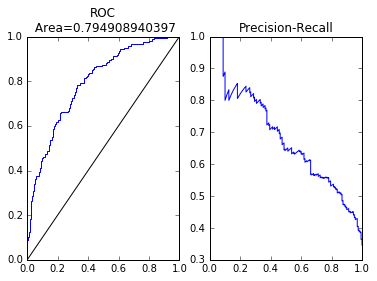

In [13]:
ROC(create_model(X,y))

Reduced model:

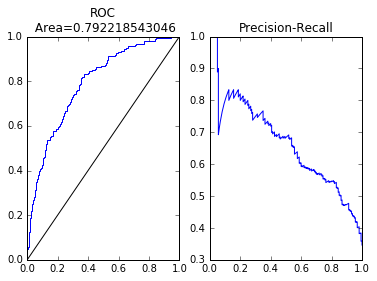

In [14]:
ROC(rm)

Single feature (9) model:

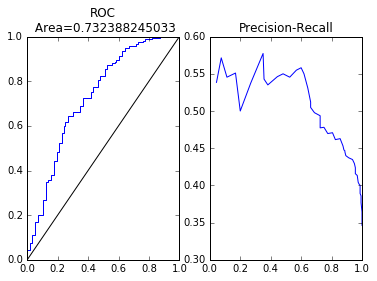

In [15]:
ROC(sfm[8])

Cross Validation

1) In the full logistic regression model (using all features), we can add a L2 based regularization term. Use cross-validation to find out the optimal regularization strength. Divide the datasets into 3 folds in the cross-validation.

In [16]:
def CV(r):
    Xcv = np.array_split(X,3)
    ycv = np.array_split(y,3)
    Cvalues = []
    for i in range(3):
        train = list(set(range(3))-set([i]))
        mr = []
        for C in (10**x for x in range(-10,10)):
            trainingX = np.concatenate((Xcv[train[0]],Xcv[train[1]]))
            trainingy = np.concatenate((ycv[train[0]],ycv[train[1]]))
            m = create_model(trainingX, trainingy, regularization=r, Cvalue=C)
            probabilities = m[0].predict_proba(Xcv[i])[:,1]
            positives = ycv[i][probabilities >= 0.5]
            negatives = ycv[i][probabilities < 0.5]
            fp = positives[positives==0].shape[0]
            fn = negatives[negatives==1].shape[0]
            mr.append(fp+fn)
        Cvalues.append(list(10**x for x in range(-10,10))[np.argmin(mr)])
        plt.subplot(1,3,i+1)
        plt.plot(list(range(-10,10)),mr)
    plt.show()
    return np.mean(Cvalues)

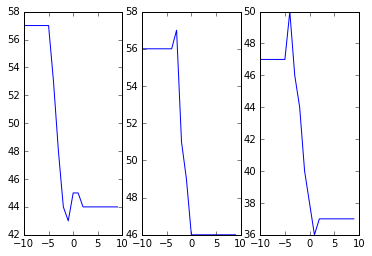

C_mean: 10e3.7


In [17]:
print ('C_mean: 10e'+str(CV('l2')))

2) Change the L2 based regularization term into L1 (Lasso) regularization and repeat the task.

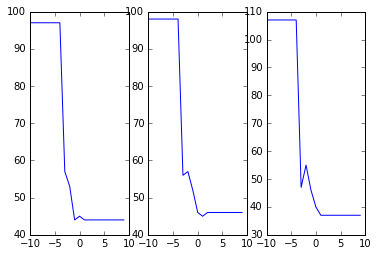

C_mean: 10e6.7


In [18]:
print ('C_mean: 10e'+str(CV('l1')))